In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split, ShuffleSplit, GroupShuffleSplit

In [4]:
from sklearn.metrics import roc_curve, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score

In [5]:
from sklearn.experimental import enable_halving_search_cv

In [6]:
from sklearn.model_selection import HalvingGridSearchCV

In [7]:
sns.set_theme(style="ticks")

In [8]:
import random

In [9]:
import collections

In [10]:
import gc

In [11]:
import utils

In [12]:
date_string = "20210720"

### Import data

In [13]:
y = np.load(utils.get_base_path("evaluation/{}_outcomes.npy".format(date_string)))

In [14]:
X = pd.read_csv(utils.get_base_path("evaluation/{}-combined.csv".format(date_string)), index_col=0, dtype=utils.get_X_dtypes())

/n/fs/grad/mmoeser/change/venv/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
X["ct_epoch"] = X["ct_block_height"] // 1008

In [16]:
X.columns

Index(['optimal_change', 'optimal_change_with_fee', 'address_type',
       'power_of_ten_2', 'power_of_ten_3', 'power_of_ten_4', 'power_of_ten_5',
       'power_of_ten_6', 'power_of_ten_7', 'fp_inout_count', 'fp_output_count',
       'fp_zeroconf', 'fp_multisig', 'fp_p2pkh', 'fp_absolute_fee',
       'fp_relative_fee', 'fp_version', 'fp_locktime', 'fp_rbf', 'fp_segwit',
       'fp_possible_segwit', 'fp_ordered_inouts', 'fp_address_type', 'fp_p2sh',
       'fp_p2wsh', 'fp_p2wpkh', 'co_output_value', 'co_is_larger_output',
       'co_output_value_ratio', 'co_output_index', 'co_fresh_output',
       'co_other_fresh', 'ct_fee', 'ct_fee_per_byte', 'ct_tx_value',
       'ct_version', 'ct_segwit_tx', 'ct_has_locktime', 'ct_block_height',
       'ct_input_count', 'ct_epoch'],
      dtype='object')

In [17]:
X.drop(columns=["ct_fee", "co_output_value", "ct_block_height", "co_is_larger_output", "co_fresh_output", "co_other_fresh"], inplace=True)

In [18]:
X_cols = X.columns

In [19]:
mask_full = np.load(utils.get_base_path("evaluation/{}_mask.npy".format(date_string)))

In [20]:
np.sum(mask_full) // 2

34398846

In [21]:
len(X) // 2

35257428

In [22]:
assert len(mask_full) == len(X)

In [23]:
X = X[mask_full].copy()
y = y[mask_full]

In [24]:
assert len(X) == np.sum(mask_full)
assert len(y) == np.sum(mask_full)

In [25]:
cluster_ids = np.load(utils.get_base_path("heuristics/{}-cluster-ids.npy".format(date_string)))

In [26]:
assert len(cluster_ids) == len(mask_full)

In [27]:
cluster_groups = cluster_ids[mask_full]

In [28]:
assert len(cluster_groups) == np.sum(mask_full)

### Compute a 80/20 split to get an out-of-bag sample

We will evaluate the performance of the optimized classifier on this sample at the end.

In [29]:
ib_idx, oob_idx = next(GroupShuffleSplit(n_splits=1, test_size=.2, random_state=1337).split(X=X, groups=cluster_groups))

In [30]:
assert len(ib_idx) + len(oob_idx) == len(X)
assert len(ib_idx) > len(oob_idx)

In [31]:
len(ib_idx) / len(X)

0.8072517607131355

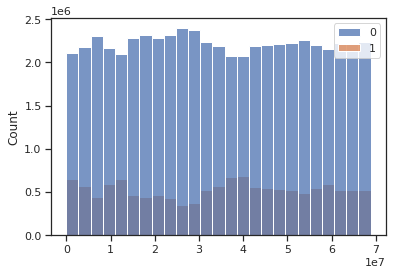

In [32]:
ax = sns.histplot([ib_idx, oob_idx], bins=25)

In [33]:
X_ib = X.iloc[ib_idx].copy()
y_ib = y[ib_idx]
X_oob  = X.iloc[oob_idx].copy()
y_oob  = y[oob_idx]

In [34]:
clusters_ib = cluster_groups[ib_idx]
clusters_oob = cluster_groups[oob_idx]

In [35]:
assert len(X_ib) == len(y_ib)
assert len(X_oob) == len(y_oob)
assert len(X_ib) + len(X_oob) == len(X)
assert len(set(X_ib.index).intersection(set(X_oob.index))) == 0

In [36]:
assert len(set(clusters_ib).intersection(set(clusters_oob))) == 0

### Apply to Out of Bag Sample (without having to rerun previous code)

In [37]:
rfc = RandomForestClassifier(random_state=1337, n_jobs=34)

In [38]:
rfc.fit(X_ib, y_ib)

RandomForestClassifier(n_jobs=34, random_state=1337)

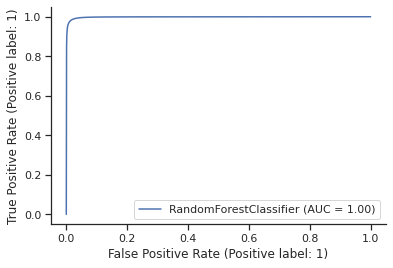

In [40]:
# Plot Out-of-bag
plot_roc_curve(rfc, X_oob, y_oob)
sns.despine()

In [41]:
roc_auc_score(y_oob, rfc.predict_proba(X_oob)[:, 1])

0.9982077979198866